# Задача EDA

### Часть 1. Парсинг

Нужно распрасить первые 40 страниц с ссылки:
https://www.litres.ru/genre/programmirovanie-5272/

In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [90]:

# Базовый URL сайта (где будут разные страницы)
base_url = 'https://www.litres.ru/genre/programmirovanie-5272/?page={}'

# Количество страниц для парсинга
total_pages = 40

# Создаем пустой DataFrame с необходимыми столбцами
df = pd.DataFrame(columns=[
    'Название', 'Автор', 'Ссылка', 'Рейтинг', 'Количество голосов', 
    'Цена', 'Количество страниц', 'Количество отзывов', 'Текст отзывов', 'Возраст', 'Год'
])

# Итерация по страницам
for page in range(1, total_pages + 1):
    # Формируем URL для каждой страницы
    url = base_url.format(page)
    
    # Делаем запрос к странице
    response = requests.get(url)
    
    # Если успешный запрос
    if response.status_code == 200:
        # Создаем объект BeautifulSoup для парсинга страницы
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Найти класс-обертку, который содержит нужные данные
        wrapper = soup.find(class_='ArtsGrid_grid__K8Emb')  # Замените wrapper-class на нужный класс
        
        # Проверяем, нашли ли обертку
        if wrapper:
            # Находим все нужные элементы внутри обертки
            items = wrapper.find_all(class_='ArtDefault_wrapper__VmWpW ArtDefault_wrapper__adaptive__VW5z0')  # Замените item-class на нужный класс
            
            # Итерация по найденным элементам
            for item in items:
                # Извлекаем данные из каждого элемента
                name = item.find(class_='ArtInfo_title__h_5Ay').text if item.find(class_='ArtInfo_title__h_5Ay') else np.nan
                author = item.find(class_='ArtInfo_author__0W3GJ').text if item.find(class_='ArtInfo_author__0W3GJ') else np.nan
                link = item.find(class_='ArtInfo_wrapper__GoMsb').find('a') 
                if link and link.has_attr('href'):
                    link = 'https://www.litres.ru' + link['href']
                else:
                    link = np.nan
                rat = item.find(class_='ArtRating_wrapper__Luk3f')
                rating = rat.find(class_='ArtRating_rating__ntve8').text if rat else np.nan
                rating_count = rat.find(class_='ArtRating_votes__MIJS1').text if rat and rat.find(class_='ArtRating_votes__MIJS1') else np.nan
                price = item.find(class_='ArtPriceFooter_ArtPriceFooterPrices__final__7AMjB').text if item.find(class_='ArtPriceFooter_ArtPriceFooterPrices__final__7AMjB') else np.nan

                # Переход на страницу книги для получения дополнительной информации
                soup1 = BeautifulSoup(requests.get(link).content, 'html.parser')
                
                # Получаем количество страниц
                pages_count = soup1.find(class_='BookCard_book__preview__data__XjF_j').find('p').text if soup1.find(class_='BookCard_book__preview__data__XjF_j') else np.nan
                
                # Получаем количество отзывов
                review_count = soup1.find(class_='CommentSystem_commentsCount__woGh3').text if soup1.find(class_='CommentSystem_commentsCount__woGh3') else np.nan
                
                # Получаем текст отзывов
                text_reviews = [y.text for y in soup1.find_all(class_='Comment_reviewText__PEkHn')]
                
                # Находим элементы с характеристиками
                characteristics_titles = soup1.find_all(class_='CharacteristicsBlock_characteristic__title__atG_Z')
                
                # Ищем индексы для 'Дата написания' и 'Возрастное ограничение'
                index_date = -1
                index_age = -1

                for i, title in enumerate(characteristics_titles):
                    if 'Дата написания' in title.text:
                        index_date = i
                    if 'Возрастное ограничение' in title.text:
                        index_age = i

                # Получаем возрастное ограничение
                age = np.nan
                if index_age != -1:
                    age = soup1.find_all(class_='CharacteristicsBlock_characteristic__4pi7v')[index_age].text
                
                # Получаем год написания
                year = np.nan
                if index_date != -1:
                    year = soup1.find_all(class_='CharacteristicsBlock_characteristic__4pi7v')[index_date].text

                # Добавляем данные в список строк для последующего объединения
                new_row = pd.DataFrame({
                    'Название': [name],
                    'Автор': [author],
                    'Ссылка': [link],
                    'Рейтинг': [rating],
                    'Количество голосов': [rating_count],
                    'Цена': [price],
                    'Количество страниц': [pages_count],
                    'Количество отзывов': [review_count],
                    'Текст отзывов': [text_reviews],
                    'Возраст': [age],
                    'Год': [year]
                })

                # Объединяем новый ряд с основным DataFrame
                df = pd.concat([df, new_row], ignore_index=True)
    else:
        print(f"Не удалось получить страницу {page}")

# Сохраняем DataFrame в CSV файл
df.to_csv('litres_books.csv', index=False)


In [6]:
# Чтоб не обращаться каждый раз к коду парсера, сохранил csv файл
df = pd.read_csv('litres_books.csv')

Дообработаем dataframe, уберем лишнее

In [7]:
df['Год'] = df['Год'].str.extract(r'(\d{4})')
df['Цена'] = df['Цена'].str.replace('\xa0', '', regex=False)  # Удаляем неразрывные пробелы
df['Цена'] = df['Цена'].str.replace('₽', '', regex=False)  # Удаляем символ "₽"
df['Цена'] = df['Цена'].str.replace(',', '.', regex=False)  # Заменяем запятую на точку

# Преобразование к типу float (для работы с дробными числами)
df['Цена'] = df['Цена'].astype(float)
df['Количество страниц'] = df['Количество страниц'].str.extract(r'(\d+)').astype(int)


In [8]:
def replace_empty_lists(lst):
    if not lst:  
        return np.nan
    return lst


df['Текст отзывов'] = df['Текст отзывов'].apply(replace_empty_lists)

## Часть 2. EDA

1. Выведите первые 5 строк датасета. (0.25). Сколько в нём строк и столбцов (0.25)?

In [9]:
print(f'Первые 5 строк')
df.head(5)

Первые 5 строк


,Название,Автор,Ссылка,Рейтинг,Количество голосов,Цена,Количество страниц,Количество отзывов,Текст отзывов,Возраст,Год
0,Изучаем DDD – предметно-ориентированное проект...,Влад Хононов,https://www.litres.ru/book/vlad-hononov/izucha...,0,NaN,549.0,319,1.0,"['Обязательно вернусь, но позжеЭта книга из то...",Возрастное ограничение: 0+,2022
1,Начинаем программировать на Python,Тони Гэддис,https://www.litres.ru/book/toni-geddis-3249116...,"4,9",16.0,599.0,875,6.0,['Шикарная книга! Начал изучать Python самосто...,Возрастное ограничение: 12+,2021
2,Высоконагруженные приложения. Программирование...,Мартин Клеппман,https://www.litres.ru/book/martin-kleppman-173...,"4,0",51.0,799.0,640,11.0,"['Не могу что-либо про перевод сказать, читал ...",Возрастное ограничение: 16+,2017
3,System Design. Подготовка к сложному интервью,Алекс Сюй,https://www.litres.ru/book/aleks-suy/system-de...,"3,6",17.0,699.0,304,9.0,['Добротная книга по разработке архитектуры пр...,Возрастное ограничение: 16+,2020
4,Нейросети начало,Джейд Картер,https://www.litres.ru/book/dzheyd-karter/neyro...,"4,9",438.0,690.0,102,37.0,['Книга отличная. Давно хотела понять как все ...,Возрастное ограничение: 12+,2023


In [10]:
print(f'Количество строк: {len(df)}')
print(f'Количество столбцов: {len(df.columns)}')

Количество строк: 960
Количество столбцов: 11


2. Есть ли в датасете пропуски? (0.5)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Название            960 non-null    object 
 1   Автор               952 non-null    object 
 2   Ссылка              960 non-null    object 
 3   Рейтинг             960 non-null    object 
 4   Количество голосов  671 non-null    float64
 5   Цена                936 non-null    float64
 6   Количество страниц  960 non-null    int64  
 7   Количество отзывов  519 non-null    float64
 8   Текст отзывов       960 non-null    object 
 9   Возраст             960 non-null    object 
 10  Год                 914 non-null    object 
dtypes: float64(3), int64(1), object(7)
memory usage: 82.6+ KB


Странно, что не везде есть цены, посмотрим, что там с версткой:

In [40]:
# Найти строки, где в столбце 'Цена' значения отсутствуют (NaN)
df[df['Цена'].isna()]

,Название,Автор,Ссылка,Рейтинг,Количество голосов,Цена,Количество страниц,Количество отзывов,Текст отзывов,Возраст,Год
423,Базовые знания тестировщика веб-приложений,Марина Охапкина,https://www.litres.ru/book/vadim-ohapkin/bazov...,4.4,237.0,NaN,67,25.0,"['Из любопытства просмотрела книгу и, как опыт...",Возрастное ограничение: 12+,2015.0
424,Python для детей. Анимация с черепашьей графикой,Виктор Рабинович,https://www.litres.ru/book/viktor-rabinovich/p...,4.0,24.0,NaN,61,2.0,"['мне понравилось, рекомендую для работы, можн...",Возрастное ограничение: 12+,2020.0
425,Программирование на Python с нуля,Максим Кононенко,https://www.litres.ru/book/maksim-kononenko-32...,3.4,30.0,NaN,10,3.0,['Действительно полезная книга. Очень помогла ...,Возрастное ограничение: 0+,2023.0
431,Занимательный Питон,nikf,https://www.litres.ru/book/nikf/zanimatelnyy-p...,3.6,42.0,NaN,7,6.0,"['Слишком кратко для начинающих,так только на ...",Возрастное ограничение: 6+,2022.0
434,Программирование приложений для мобильных устр...,Евгений Владимирович Сенько,https://www.litres.ru/book/evgeniy-senko/progr...,4.1,83.0,NaN,129,6.0,['В книге рассказано и показано программирован...,Возрастное ограничение: 12+,2015.0
438,Устойчивый веб-дизайн,Jeremy Keith,https://www.litres.ru/book/jeremy-keith-322601...,3.9,8.0,NaN,83,2.0,['Оценка 0. Это простое чтиво с какими-то слов...,Возрастное ограничение: 12+,2022.0
440,Как написать и продать свой PHP скрипт,Самуэль Акопян,https://www.litres.ru/book/samuel-akopyan/kak-...,4.6,10.0,NaN,95,3.0,"['Вот уж что не ожидал, так обнаружить подобну...",Возрастное ограничение: 12+,2021.0
443,Брать или не брать? или Как собеседовать разра...,Константин Евгеньевич Борисов,https://www.litres.ru/book/konstantin-evgenevi...,4.6,98.0,NaN,106,12.0,"['Мне книга понравилась.Она недлинная, прочита...",Возрастное ограничение: 18+,2018.0
445,Табличный ПЛК.Табличное программирование контр...,Владимир Васильевич Стретенцев,https://www.litres.ru/book/stretencev-vasilevi...,5.0,5.0,NaN,141,1.0,['Очень своевременная книга. Крайне актуальна ...,Возрастное ограничение: 12+,2023.0
446,Обратные вызовы в C++,Виталий Евгеньевич Ткаченко,https://www.litres.ru/book/vitaliy-evgenevich-...,5.0,2.0,NaN,206,1.0,['Книга прекрасно раскрывает тему. Не просто п...,Возрастное ограничение: 12+,2020.0


Видимо это бесплатные книги.
Остальные пропуски это проблема в составление карточек продуктов, и таких значений не очень много.

3. Проверьте типы данных. Если это необходимо, приведите к типам int и float те столбцы, с которыми понадобится работать как с числами. (1).

In [13]:
df.dtypes

Название               object
Автор                  object
Ссылка                 object
Рейтинг                object
Количество голосов    float64
Цена                  float64
Количество страниц      int64
Количество отзывов    float64
Текст отзывов          object
Возраст                object
Год                    object
dtype: object

Переведем некоторые колонки в необходимые типы данных

In [14]:
df['Рейтинг'] = df['Рейтинг'].str.replace(',', '.', regex=False)  # Заменяем запятую на точку
df['Рейтинг'] = df['Рейтинг'].astype(float)

In [15]:
df['Количество голосов'] = df['Количество голосов'].astype(float)
df['Количество отзывов'] = df['Количество отзывов'].astype(float)
df['Год'] = df['Год'].astype(float)

In [16]:
df.dtypes

Название               object
Автор                  object
Ссылка                 object
Рейтинг               float64
Количество голосов    float64
Цена                  float64
Количество страниц      int64
Количество отзывов    float64
Текст отзывов          object
Возраст                object
Год                   float64
dtype: object

4. Выведите описательные статистики переменных. Ответьте на следующие вопросы:
- Какая медианная цена книги в вашем датасете? (1)
- Какое возрастное ограничение встречается чаще всего? (1)
- Какое среднее число отзывов в книге? (1)
- Сколько книг имеют оценку ниже 4.25? (1)
- В каком году было написано больше всего книг из датасета? (1)

In [56]:
median_value = df['Цена'].median()
print(f'Медианная цена книги: {median_value}')
class_counts = df['Возраст'].value_counts().iloc[:1]
print(f'Чаще всего встречается {class_counts}')
average_otzoviy = df['Количество отзывов'].fillna(0).mean()
print(f'Среднее число отзывов в книге: {average_otzoviy.astype(float)}')
number_of_books_loweer_than = (df['Рейтинг']<4.25).sum()
print(f'Число книг имеющих оценку ниже 4.25:  {number_of_books_loweer_than}')

productivity_year = df['Год'].value_counts().iloc[:1]
print(f'Больше всего книг написано в :  {productivity_year}')

Медианная цена книги: 339.0
Чаще всего встречается Возраст
Возрастное ограничение: 0+    531
Name: count, dtype: int64
Среднее число отзывов в книге: 2.3177083333333335
Число книг имеющих оценку ниже 4.25:  558
Больше всего книг написано в :  Год
2023.0    116
Name: count, dtype: int64


5. Если вы работаете с готовым датасетом, то попробуйте "достать" из столбца pages количество страниц. Если у вас не получилось, то далее при определении числа страниц пользуйтесь стольцов pages_count. Если вы парсили датасет сами, то вы получаете балл за этот пункт автоматически (1.5)

6. Создайте новое поле is_popular. Значение равно 1, если рейтинг книги не менее 4.6 и при этом у нее не менее 5 отзывов, и 0 в остальных случаях. (1)

In [58]:
df['is_popular'] = ((df['Рейтинг'] >= 4.6) & (df['Количество отзывов'] >= 5)).astype(int)
df.head(5)

,Название,Автор,Ссылка,Рейтинг,Количество голосов,Цена,Количество страниц,Количество отзывов,Текст отзывов,Возраст,Год,is_popular
0,Изучаем DDD – предметно-ориентированное проект...,Влад Хононов,https://www.litres.ru/book/vlad-hononov/izucha...,0.0,NaN,549.0,319,1.0,"['Обязательно вернусь, но позжеЭта книга из то...",Возрастное ограничение: 0+,2022.0,0
1,Начинаем программировать на Python,Тони Гэддис,https://www.litres.ru/book/toni-geddis-3249116...,4.9,16.0,599.0,875,6.0,['Шикарная книга! Начал изучать Python самосто...,Возрастное ограничение: 12+,2021.0,1
2,Высоконагруженные приложения. Программирование...,Мартин Клеппман,https://www.litres.ru/book/martin-kleppman-173...,4.0,51.0,799.0,640,11.0,"['Не могу что-либо про перевод сказать, читал ...",Возрастное ограничение: 16+,2017.0,0
3,System Design. Подготовка к сложному интервью,Алекс Сюй,https://www.litres.ru/book/aleks-suy/system-de...,3.6,17.0,699.0,304,9.0,['Добротная книга по разработке архитектуры пр...,Возрастное ограничение: 16+,2020.0,0
4,Нейросети начало,Джейд Картер,https://www.litres.ru/book/dzheyd-karter/neyro...,4.9,438.0,690.0,102,37.0,['Книга отличная. Давно хотела понять как все ...,Возрастное ограничение: 12+,2023.0,1


7. Как отличается среднее число страниц среди популярных и непопулярных книг? (2)

In [59]:
mean_pages_popular = df[df['is_popular'] == 1]['Количество страниц'].mean()

# Вычисляем среднее число страниц для непопулярных книг
mean_pages_unpopular = df[df['is_popular'] == 0]['Количество страниц'].mean()

# Выводим результаты
print(f"Среднее число страниц среди популярных книг: {mean_pages_popular}")
print(f"Среднее число страниц среди непопулярных книг: {mean_pages_unpopular}")

Среднее число страниц среди популярных книг: 344.55263157894734
Среднее число страниц среди непопулярных книг: 238.19088937093275


8.Выведите топ-10 книг по числу отзывов. (2).

In [65]:
top_10_books = df.sort_values(by='Количество отзывов', ascending=False).head(10)

# Выводим результат
print(top_10_books['Название'])

459                                 Оптимизация в Python
4                                       Нейросети начало
202    Психбольница в руках пациентов. Алан Купер об ...
116    Теоретический минимум по Computer Science. Все...
488    Говорят, в IT много платят. Как построить успе...
337    Идеальный программист. Как стать профессионало...
141    #Сам себе программист. Как научиться программи...
423           Базовые знания тестировщика веб-приложений
38                   Сделай видеоигру один и не свихнись
224                  Сделай видеоигру один и не свихнись
Name: Название, dtype: object


9. Найдите среднюю длину отзыва (в символах). (2)

In [ ]:
import ast
df['Текст отзывов'] = df['Текст отзывов'].apply(ast.literal_eval)
# Вычисляем среднюю длину всех отзывов

In [97]:
mean_review_length = df['Текст отзывов'].apply(
    lambda review_list: sum(len(review) for review in review_list) / len(review_list) if review_list else 0
).mean()
print(f'Средняя длина отзывов: {mean_review_length}')

Средняя длина отзывов: 192.96334325396825


10.Постройте таблицу корреляций числовых переменных.(1) Прокомментируйте результаты. (1)

In [101]:
correlation_matrix = df[['Год','Количество отзывов','Рейтинг','Количество голосов','Цена','Количество страниц','Год']].corr()

# Вывод таблицы корреляций
print(correlation_matrix)

                         Год  Количество отзывов   Рейтинг  \
Год                 1.000000           -0.019018  0.293781   
Количество отзывов -0.019018            1.000000  0.046807   
Рейтинг             0.293781            0.046807  1.000000   
Количество голосов  0.087071            0.652487  0.092584   
Цена                0.423583            0.106705  0.394578   
Количество страниц  0.116130            0.011884  0.400917   
Год                 1.000000           -0.019018  0.293781   

                    Количество голосов      Цена  Количество страниц       Год  
Год                           0.087071  0.423583            0.116130  1.000000  
Количество отзывов            0.652487  0.106705            0.011884 -0.019018  
Рейтинг                       0.092584  0.394578            0.400917  0.293781  
Количество голосов            1.000000  0.139643            0.000205  0.087071  
Цена                          0.139643  1.000000            0.558607  0.423583  
Количество страни

Наиболее значимые кореляции заметны в следующих парах:
- Количество голосов - Количество отзывов
- Цена - количество страниц

11. Постройте диаграмму рассеяния (scatterplot) количества страниц и количества отзывов. Не забудьте подписать график и оси. (1) 
Прокомментируйте полученные результаты. (1)



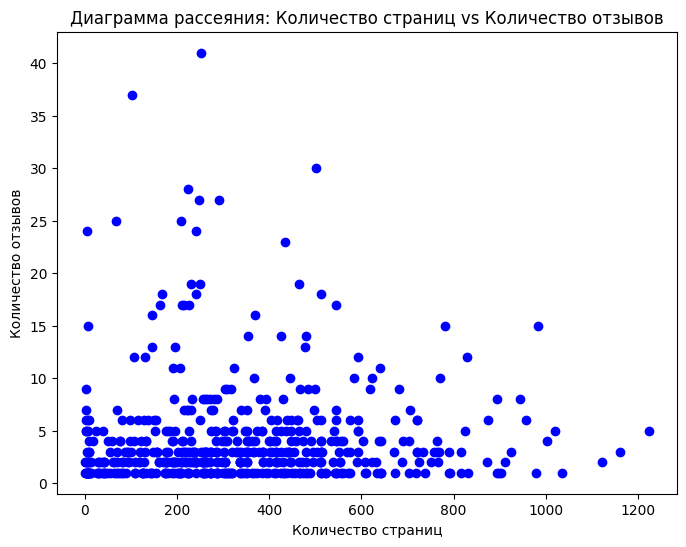

In [102]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(df['Количество страниц'], df['Количество отзывов'], color='blue')

# Подписи осей
plt.xlabel('Количество страниц')
plt.ylabel('Количество отзывов')

# Заголовок графика
plt.title('Диаграмма рассеяния: Количество страниц vs Количество отзывов')

# Отображение графика
plt.show()

Какой-либо кореляии не видно.

От количества страниц, количество отзывов не увеличивается

12. Постройте линейный график: по оси Х год, по оси Y количество книг. (1) Прокомментируйте. (1)

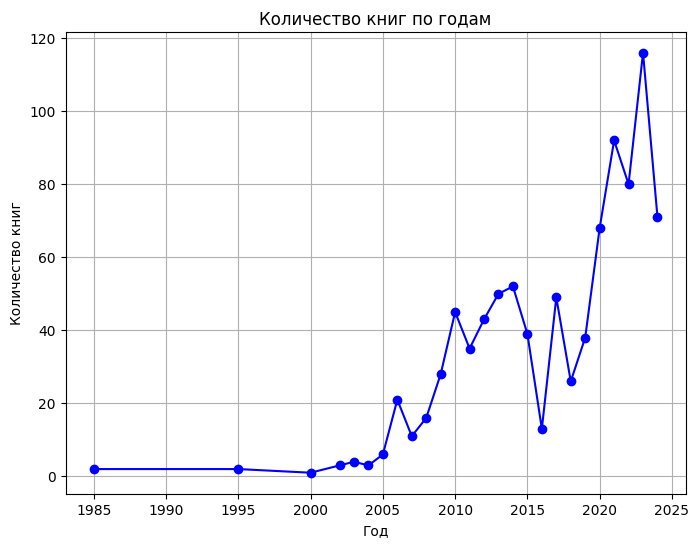

In [105]:
books_per_year = df.groupby('Год').size()

plt.figure(figsize=(8, 6))
plt.plot(books_per_year.index, books_per_year.values, marker='o', linestyle='-', color='b')


plt.xlabel('Год')
plt.ylabel('Количество книг')

plt.title('Количество книг по годам')


plt.grid(True)
plt.show()

Наблюдается максимум в 2023 году, и резкий рост начиная с 2018.
Это можно связать с тем, что мы смотрим популярные книги, в которых есть алгоримты продвигающие новые книги, и в целом новые книги по техническим тема читают чаще, чем старые.

Также можно предположить, что рост начинается с 2005 года, возможно это связано с открытием litres

**UPD**: https://ru.wikipedia.org/wiki/Литрес - оказалось правдой

13. Постройте еще любые два графика по вашему усмотрению. (2) Прокомментируйте полученные результаты. (1.5)

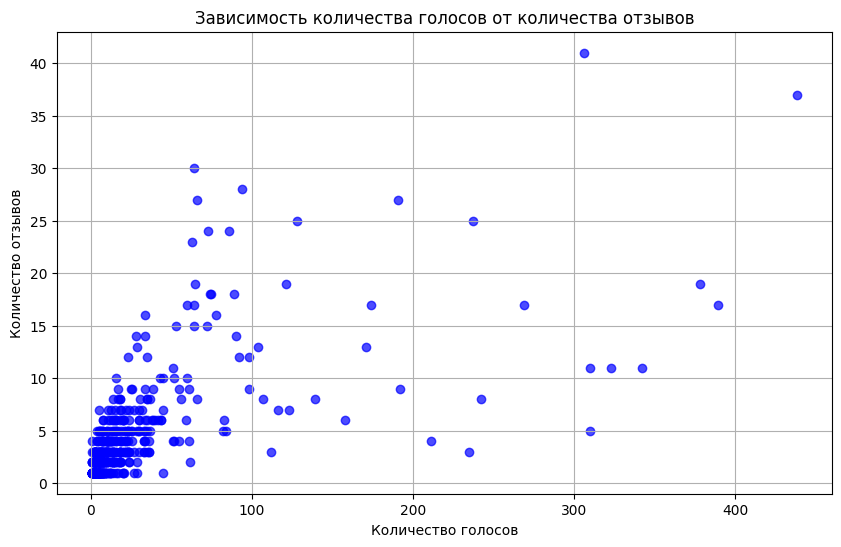

In [107]:
# Построение диаграммы рассеяния количества страниц против рейтинга
plt.figure(figsize=(10, 6))
plt.scatter(df['Количество голосов'], df['Количество отзывов'], color='blue', alpha=0.7)
plt.title('Зависимость количества голосов от количества отзывов')
plt.xlabel('Количество голосов')
plt.ylabel('Количество отзывов')
plt.grid(True)
plt.show()

Видна небольшая корелляция между числом голосов и количеством отзывов

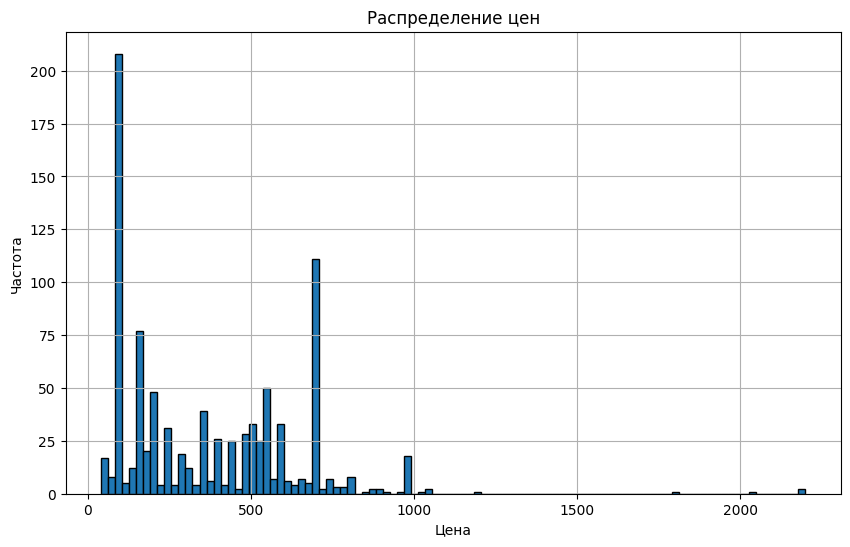

In [114]:
# Построение гистограммы распределения цен
plt.figure(figsize=(10, 6))
plt.hist(df['Цена'], bins=100, edgecolor='black')
plt.title('Распределение цен')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

Видно два ценовых пика

14. Постройте таблицу с авторами книг с именем автора, количество книг в датасете, средней оценкой книг, средним количеством отзывов. (2).

In [120]:
author_stats = df.groupby('Автор').agg(
    Количество_книг=('Название', 'size'),
    Средняя_оценка=('Рейтинг', 'mean'),
    Среднее_количество_отзывов=('Количество отзывов', 'mean')
).reset_index()

# Переименуем колонки для удобства
author_stats.columns = ['Автор', 'Количество книг', 'Средняя оценка', 'Среднее количество отзывов']
author_stats = author_stats.sort_values(by='Количество книг', ascending=False)
print(author_stats)

                  Автор  Количество книг  Средняя оценка  \
239        Джейд Картер               24        4.937500   
604        Тимур Машнин               17        4.682353   
312    Е. Ю. Хрусталева               11        3.245455   
114     Артем Демиденко               11        4.263636   
191     Владимир Дронов               11        4.190909   
..                  ...              ...             ...   
6          Jeremy Keith                1        3.900000   
5    Jean-Loup Chrétien                1        4.300000   
4           Jade Carter                1        0.000000   
1         C. И. Никишов                1        4.700000   
0          Arsen Gonian                1        5.000000   

     Среднее количество отзывов  
239                   11.900000  
604                    3.285714  
312                    3.750000  
114                    2.142857  
191                    3.000000  
..                          ...  
6                      2.000000  
5      

15. Что еще интересного можно увидеть в этом датасете? Просмотрите на данные и ответьте на какие-нибудь вопросы, на которые не ответили в предыдущим пункте. Мы никак не ограничиваем вашу фантазию! (3).

Все что было интересно, я узнал.